## 神经网络定义

* 用于更新节点 j 与下一层节点 k 之间链接权重的矩阵形式的表达式：$\Delta \omega_{j,k} = \alpha * E_{k} * sigmoid(O_{k}) * (1 - sigmoid(O_{k})) \cdot O_{j}^{T}$
  * $\alpha$ 学习率，$E$ 是误差矩阵，$sigmoid$ 是激活函数，$O$ 是上一层的输出矩阵
  * $*$ 乘法是正常的对应元素的乘法，$\cdot$ 点乘是矩阵点积
  * 注意，来自上一层的输出矩阵被转置了，意味着输出矩阵的列变成了行

In [183]:
import scipy
import numpy as np


class NeuralNetwork():
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        """
        神经网络类的初始化
        :params input_nodes: int，输入层节点数量
        :params hidden_nodes: int，隐藏层节点数量
        :params output_nodes: int，输出层节点数量
        :params learning_rate: float，学习率
        """
        self._input_nodes = input_nodes
        self._hidden_nodes = hidden_nodes
        self._output_nodes = output_nodes
        
        self._learning_rate = learning_rate
        
        # 权重，使用正态概率分布采样权重，其中平均值为0，标注方差为节点传入链接数据的开方
        self._weight_input_hidden = np.random.normal(0.0, pow(self._hidden_nodes, -0.5), (self._hidden_nodes, self._input_nodes))
        self._weight_hidden_output = np.random.normal(0.0, pow(self._output_nodes, -0.5), (self._output_nodes, self._hidden_nodes))
        
        # 激活函数
        self.activation_function = lambda x: scipy.special.expit(x)  # sigmoid 函数
        pass
    
    def train(self, inputs_list, targets_list):
        """
        神经网络的训练
        :params inputs_list: list，一维列表，输入值
        :params targets_list: list，一维列表，目标值
        """
        # 1. 同 query()，计算实际输出
        inputs, hidden_outputs, final_outputs = self.query(inputs_list)
        
        # 2.对比实际输出值与预期值，使用差值来指导网络权重的更新
        targets = np.array(targets_list, ndmin=2).T
        output_errors = targets - final_outputs  # 隐藏层和输出层之间的误差
        hidden_errors = np.dot(self._weight_hidden_output.T, output_errors)  # 输入层和隐藏层之间的误差
        
        # 3.更新权重
        # 更新隐藏隐藏层和输出层之间的链接权重
        self._weight_hidden_output += self._learning_rate * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), 
                                                                  np.transpose(hidden_outputs))
        # 更新输入层和隐藏层之间的链接权重
        self._weight_input_hidden += self._learning_rate * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), 
                                                                 np.transpose(inputs))
        pass
    
    def query(self, inputs_list):
        """
        神经网络类的查询/计算
        这里每个节点都使用了激活函数
        :params inputs_list: list，一维列表，输入值
        :return: inputs, hidden_outputs, final_outputs
        """
        # 将输入列表转换为 2d 的 ndarray
        inputs = np.array(inputs_list, ndmin=2).T
        
        # 计算隐藏层的输出
        hidden_inputs = np.dot(self._weight_input_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # 计算第三层（最后一层）的输出
        final_inputs = np.dot(self._weight_hidden_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return inputs, hidden_outputs, final_outputs


In [184]:
# 简单使用
input_nodes = 3
hidden_nodes = 3
output_nodes = 3

learning_rate = 0.3

nn = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
inputs, hidden_outputs, final_outputs = nn.query([1.0, 0.5, -1.5])
final_outputs

array([[ 0.24617405],
       [ 0.52526267],
       [ 0.12365428]])

## 识别手写数字数据集 MNIST

##### 下载地址
###### 训练集：https://pjreddie.com/media/files/mnist_train.csv
###### 测试集：https://pjreddie.com/media/files/mnist_test.csv
> 数据集样本中：
> 1. 每行表示一个一个样本
> 2. 第一个值是标签，即 target；随后的 28*28 共 784 个值是手写的像素值

In [185]:
import sys
sys.path.append('/home/centos/leon/machine_learning_jupyter')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [206]:
# 样本示例，原训练集有 6W 个样本，大小超过 100MB 被 GitHub 拦截，顾这里分为了两个文件
df_train1 = pd.read_csv('/home/centos/leon/machine_learning_jupyter/dataset/mnist_train_1.csv', header=None)
df_train2 = pd.read_csv('/home/centos/leon/machine_learning_jupyter/dataset/mnist_train_2.csv', header=None)
df_train = df_train1.append(df_train2)
pd.set_option('display.max_columns', None)
print df_train.shape
df_train.head()

(60000, 787)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786
0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,1,154,253,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,253,190,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,190,253,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,241,225,160,108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,240,2

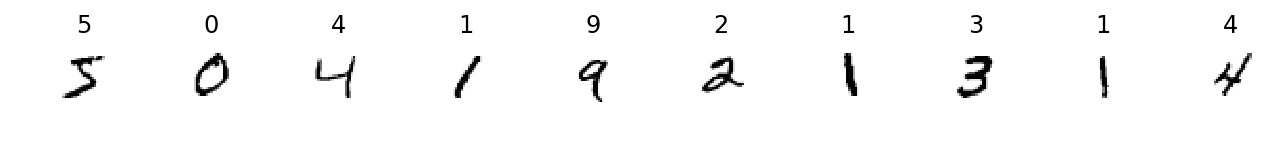

In [187]:
# 显示前10张手写数字
n = 10

plt.figure(figsize=(9, 3), dpi=144)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(df_train.iloc[i, 1:].values.reshape((28, 28)), cmap='Greys', interpolation='None')
    plt.title(str(df_train.iloc[i, 0]))
    plt.axis('off')
    plt.tight_layout()
    pass
plt.show()

In [188]:
# 使用手写数据集训练神经网络
input_nodes = 784  # 对应手写图像的 28*28 个像素输入值
hidden_nodes = 100
output_nodes = 10  # 对应 10 种标签

learning_rate = 0.3

nn = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# 加载训练集
training_data_file = open('/home/centos/leon/machine_learning_jupyter/dataset/mnist_train.csv', 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# 训练神经网络
start_time = time.time()
for data in training_data_list:
    all_values = data.split(',')
    # 输入颜色值从 0 到 255，需要缩放至 0.01 到 1.0 范围
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # 标签是长度为 10 的一维数组。试图让神经网络生成 0 和 1的输出，对于激活函数而言是不可能的，这会导致大的权重和饱和网络，
    # 因此需要重新调整，将 0 和 1 用 0.01 和 0.99 代替。如，标签为'5'的目标值，输出数组为：[0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01]
    targets = np.zeros(output_nodes) + 0.01
    targets[int(all_values[0])] = 0.99  # 如 int(all_values[0])=5，则 targets[5]=0.99
    
    nn.train(inputs, targets)
    pass
print '训练完毕，耗时：', int(time.time() - start_time), ' 秒'

训练完毕，耗时： 32  秒


In [189]:
# 测试网络

# 加载测试集
df_test = pd.read_csv('/home/centos/leon/machine_learning_jupyter/dataset/mnist_test.csv', header=None)

test_data_file = open('/home/centos/leon/machine_learning_jupyter/dataset/mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

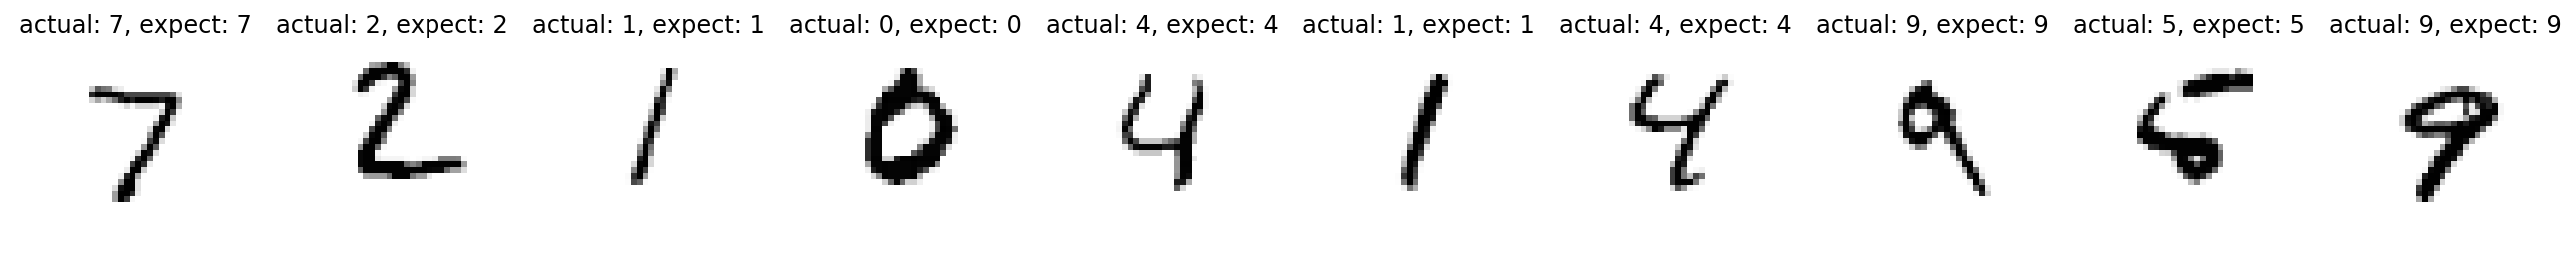

In [190]:
# 显示前10张手写数字的识别情况
n = 10

def output_2_target(outputs):
    """
    将神经网络的输出转换为具体识别的数字
    :params outputs: list，一维数组，神经网络的最终输出
    :return: target
    """
    max_output = outputs[0]
    target = 0
    for i in range(len(outputs)):
        if outputs[i] > max_output:
            max_output = outputs[i]
            target = i
    return target

plt.figure(figsize=(18, 3), dpi=144)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(df_test.iloc[i, 1:].values.reshape((28, 28)), cmap='Greys', interpolation='None')
    inputs = (np.asfarray(test_data_list[i].split(',')[1:]) / 255.0 * 0.99) + 0.01
    inputs, hidden_outputs, final_outputs = nn.query(inputs)
    plt.title('actual: {}, expect: {}'.format(str(output_2_target(final_outputs)), str(df_test.iloc[i, 0])))
    plt.axis('off')
    plt.tight_layout()
    pass
plt.show()

In [191]:
# 分析测试集测成功率
def gen_neural_network_score(neural_network_model, test_data_list):
    true_num = 0
    for test_data in test_data_list:
        all_values = test_data.split(',')
        expect = str(all_values[0])
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        inputs, hidden_outputs, final_outputs = nn.query(inputs)
        actual = str(output_2_target(final_outputs))
        if expect == actual:
            true_num += 1
        pass
    return 1.0 * true_num / len(test_data_list)

print '识别正确率：{}'.format(gen_neural_network_score(nn, test_data_list))

识别正确率：0.9405


In [195]:
# 分析不同学习率的情况下的性能
learning_rates = np.linspace(0.1, 0.9, 9).tolist()

max_score = 0
max_score_learning_rate = None
for lr in learning_rates:
    neural_network_model = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, lr)
    start_time = time.time()
    for data in training_data_list:
        all_values = data.split(',')
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = np.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        neural_network_model.train(inputs, targets)
        pass
    score = gen_neural_network_score(neural_network_model, test_data_list)
    if score > max_score:
        max_score = score
        max_score_learning_rate = lr
    print '学习率：{}，训练测试耗时：{}，识别正确率：{}'.format(lr, int(time.time() - start_time), score)
    pass
print '综上，最佳学习率：{}，识别正确率：{}'.format(max_score_learning_rate, max_score)

学习率：0.1，训练测试耗时：31，识别正确率：0.9405
学习率：0.2，训练测试耗时：33，识别正确率：0.9405
学习率：0.3，训练测试耗时：37，识别正确率：0.9405
学习率：0.4，训练测试耗时：36，识别正确率：0.9405
学习率：0.5，训练测试耗时：36，识别正确率：0.9405
学习率：0.6，训练测试耗时：36，识别正确率：0.9405
学习率：0.7，训练测试耗时：37，识别正确率：0.9405
学习率：0.8，训练测试耗时：36，识别正确率：0.9405
学习率：0.9，训练测试耗时：36，识别正确率：0.9405
综上，最佳学习率：0.1，识别正确率：0.9405
